In [0]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os, json
from google.colab import drive
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
from skimage.segmentation import mark_boundaries

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Import depedences from google drive

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final'

/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final


In [5]:
!ls

cm_data_set_exp1.png  dataset_final.tar.xz		train_val_phase.csv
dataset_final	      restnet_model152_trained_exp7.pt


## Download lime with pip

In [6]:
!pip install lime

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=dd04b2c8c1df8dc6c5ecddb11ecb46f12c5bea660e23f9ca6617819ad7a78251
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
from lime import lime_image

## Using Lime with Pytorch

Based on a oficial repo's notebook

Image preview 

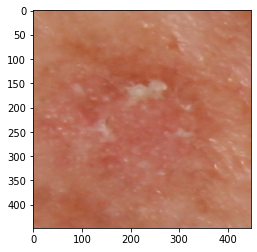

In [13]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/dataset_final/test/actinic-keratosis/1604.jpg')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply transformations in order to feed our pretrained model

In [0]:
def get_input_transform():
  '''
  Pre transformations applied on the image
  '''
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
  transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

  return transf

def get_input_tensors(img):
  '''
  Convert image to feed the model
  '''
  transf = get_input_transform()
  # unsqeeze converts single image to batch of 1
  return transf(img).unsqueeze(0)

### Load the skin lession model

In [0]:
PRE_MODEL_DIR='/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/restnet_model152_trained_exp7.pt'

In [0]:
model_name='resnet'
num_classes = 9
feature_extract = False

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [19]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 115MB/s]


In [20]:
if train_on_gpu:
    state = torch.load(PRE_MODEL_DIR)
else:
    state = torch.load(PRE_MODEL_DIR, map_location='cpu')

# Loading weights in restnet architecture
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [21]:
classes_skin = state['class_to_idx']
classes_skin

{'actinic-keratosis': 0,
 'basal-cell-carcinoma': 1,
 'dermatofibroma': 2,
 'hemangioma': 3,
 'intraepithelial-carcinoma': 4,
 'malignant-melanoma': 5,
 'melanocytic-nevus': 6,
 'pyogenic-granuloma': 7,
 'squamous-cell-carcinoma': 8}

In [0]:
classes_skin = { "0": ['n09246464','actinic-keratosis'],
  "1": ['n09246465','basal-cell-carcinoma'],
  "2": ['n09246468','dermatofibroma'],
  "3": ['n09246467','hemangioma'],
  "4": ['n09246468','intraepithelial-carcinoma'],
  "5": ['n09246469','malignant-melanoma'],
  "6": ['n09246470','melanocytic-nevus'],
  "7": ['n09246471','pyogenic-granuloma'],
  "8": ['n09246472','squamous-cell-carcinoma']}

In [0]:
idx2label = [] 
cls2label = {}
cls2idx = {}

idx2label = [classes_skin[str(k)][1] for k in range(len(classes_skin))]
cls2label = {classes_skin[str(k)][0]: classes_skin[str(k)][1] for k in range(len(classes_skin))}
cls2idx = {classes_skin[str(k)][0]: k for k in range(len(classes_skin))}

In [0]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [31]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.9862705, 0, 'actinic-keratosis'),
 (0.012574257, 1, 'basal-cell-carcinoma'),
 (0.0010640207, 6, 'melanocytic-nevus'),
 (8.0221376e-05, 8, 'squamous-cell-carcinoma'),
 (8.916402e-06, 3, 'hemangioma'))

In [0]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [0]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [34]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

In [0]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

Let's use mask on image and see the areas that are encouraging the top prediction.

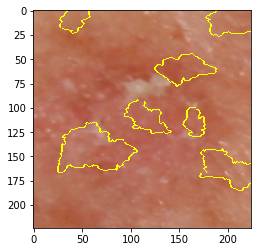

In [86]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

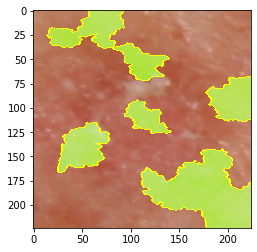

In [82]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
